<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

__Описание данных__

_Технологический процесс_
* `Rougher feed` — исходное сырье
* `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant
 * `Xanthate` — ксантогенат (промотер, или активатор флотации);
 * `Sulphate` — сульфат (на данном производстве сульфид натрия);
 * `Depressant` — депрессант (силикат натрия).
* `Rougher process (англ. «грубый процесс»)` — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

_Параметры этапов_
* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

## Подготовка данных

In [1]:
#импортируем библиотеки

import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import  make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#настроим формат вывода данных

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#считаем файлы с данными и сохраним в датафреймы

pth1 = '/datasets/gold_industry_train.csv'
pth2 = '/datasets/gold_industry_test.csv'
pth3 = '/datasets/gold_industry_full.csv'
    
if os.path.exists(pth1):
    data_train = pd.read_csv(pth1, index_col=['date'])
if os.path.exists(pth2):
    data_test = pd.read_csv(pth2, index_col=['date'])
if os.path.exists(pth3):
    data_full = pd.read_csv(pth3, index_col=['date'])
else: 
    print('Something is wrong')

In [4]:
#выведем первые строки и общую информацию

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

In [6]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [7]:
data_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57

In [8]:
data_test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,1147.248241,-500.363165,1047.279065,-500.354091,948.756608,-498.439416,849.441918,-499.255503,850.112246,-499.407112,6.168939,9.309852,95.248427,8.078957,6.500000,1.283045,1648.759906,-399.862053,1650.135395,-399.957321,1648.831890,-400.586116,1649.464582,-400.673303,34.940919,-500.150510,30.031867,-500.328335,26.033990,-500.147792,22.952306,-500.037678,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561,6.209517,9.297194,98.880538,7.984164,6.500000,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,1651.498591,-399.745329,34.980742,-498.131002,29.968453,-586.013330,25.971737,-499.608392,22.958448,-499.821308,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,1150.754676,-499.986009,1049.182824,-500.014696,948.085464,-499.997003,850.170086,-500.270334,849.557905,-500.198702,7.358308,9.000624,119.497545,8.003752,6.500000,1.259741,1647.368779,-399.788506,1648.395206,-400.166490,1648.953828,-400.468641,1649.821569,-400.071884,34.952967,-501.204647,29.927025,-500.106628,25.978253,-499.890060,23.004376,-500.014529,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,1152.512559,-500.338106,1052.601592,-499.695075,955.171539,-500.294989,851.957342,-499.779541,850.765662,-501.030559,6.929364,8.920717,108.080163,7.970121,6.660000,0.774909,1652.660845,-399

In [9]:
data_full.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57

In [10]:
#проверим на наличие строк-дубликатов

print(data_full.duplicated().sum())
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())

0
0
0


In [11]:
#проверим на наличие аномальных значений

data_full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19395.000000,18986.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,19439.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439

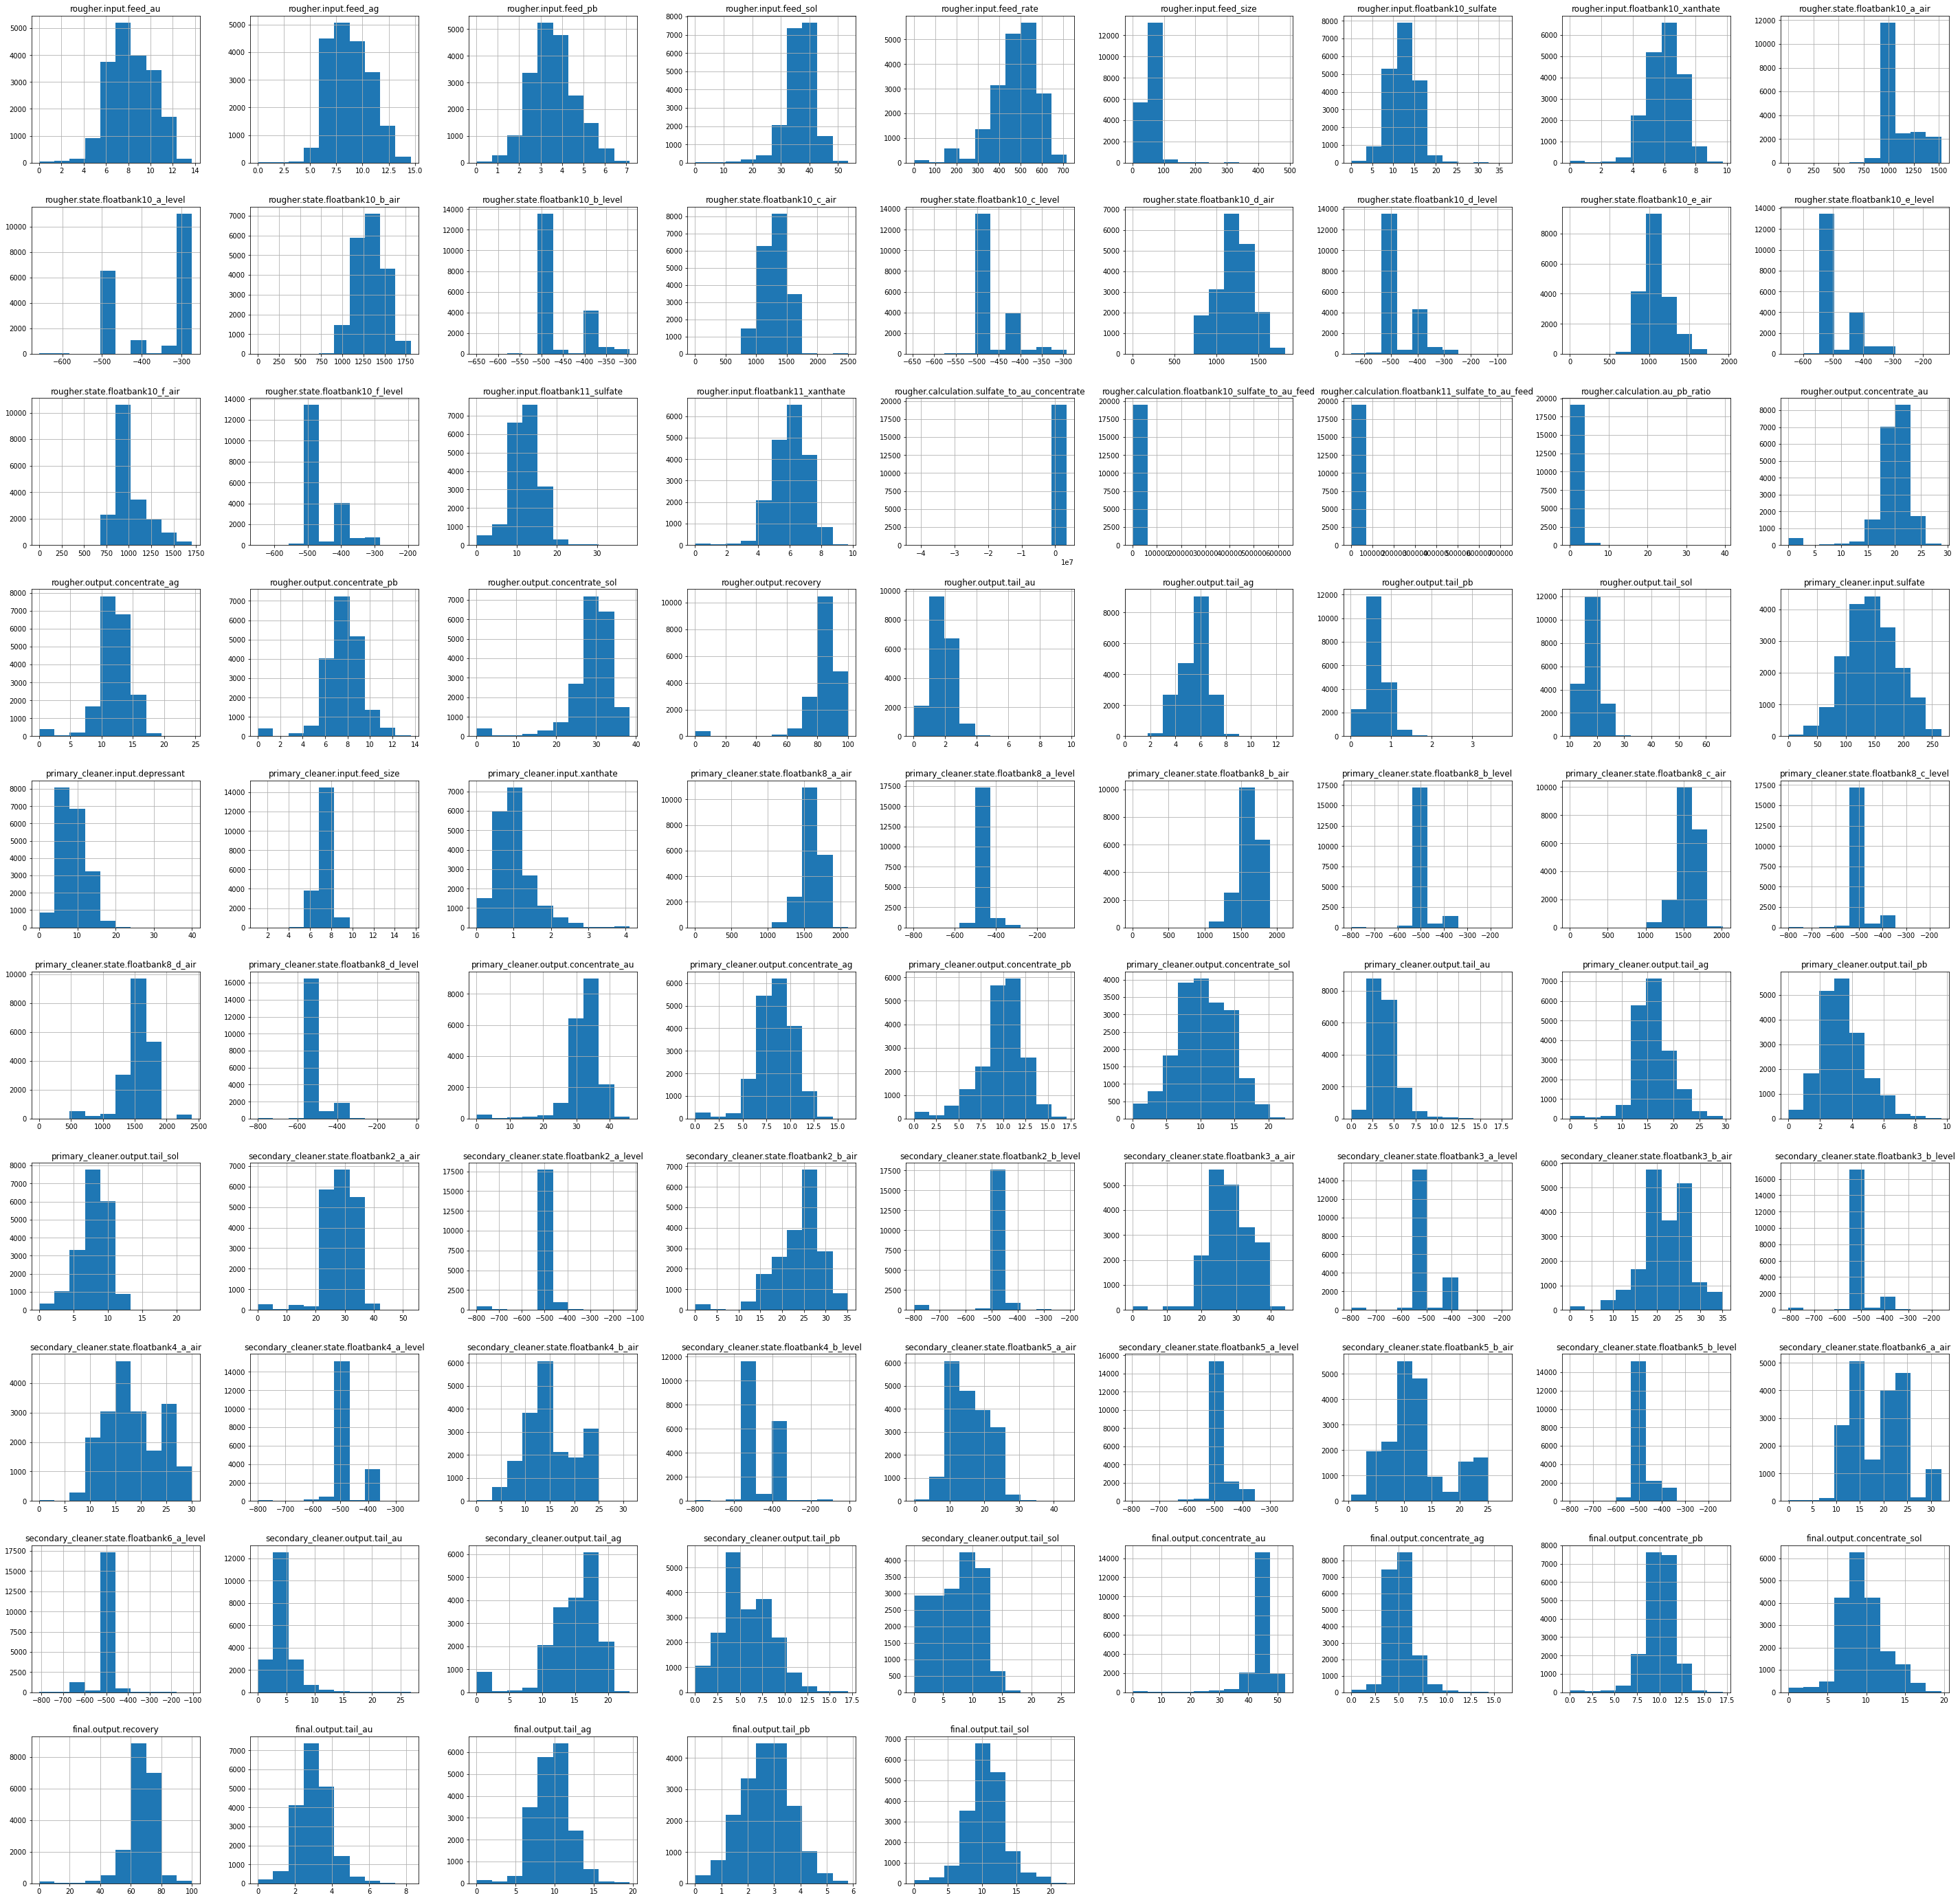

In [12]:
data_full.hist(figsize=(50, 50))
plt.show()

In [13]:
data_full.corr()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
rougher.input.feed_au,1.000000,0.845274,0.687003,0.094392,-0.190381,-0.152634,0.294588,0.208971,0.154849,-0.102113,-0.110896,-0.027711,-0.105514,-0.020486,-0.146770,-0.016977,-0.155476,0.008516,-0.190439,0.010265,0.248287,0.208769,-0.012053,-0.070768,-0.068910,0.034491,0.232677,0.305916,0.004302,0.221388,0.183814,0.379195,0.471177,0.094770,-0.219683,0.620644,0.399121,0.132383,0.238643,0.025876,-0.061465,0.062629,-0.044510,0.007873,-0.052286,0.129205,-0.084724,-0.119264,0.442915,0.204538,0.476985,0.290565,0.220107,0.306911,0.431834,-0.155525,-0.035532,-0.089387,-0.033739,-0.019600,0.044110,0.016690,-0.010061,-0.063298,0.080605,0.037087,-0.049987,-0.162136,0.055641,-0.127207,0.089231,0.005793,-0.080820,0.144300,0.079168,-0.168546,0.242171,0.035095,0.315817,-0.079812,0.474520,0.295343,0.642479,0.594311,0.494324,-0.008907
rougher.input.feed_ag,0.845274,1.000000,0.496579,0.115878,-0.134165,-0.110868,0.106487,0.231607,0.278293,-0.124046,-0.126267,-0.057898,-0.149086,-0.049670,-0.167924,-0.045655,-0.113799,-0.042182,-0.160578,-0.038448,0.091833,0.219753,-0.013346,-0.0

In [14]:
#проверим расчет эффективности обогащения на обучающей выборке для признака rougher.output.recovery

def check(row):
    (output_au, input_au, tail_au, output_recovery) = (row['rougher.output.concentrate_au'],
                                                       row['rougher.input.feed_au'],
                                                       row['rougher.output.tail_au'],
                                                       row['rougher.output.recovery'])
    if ((input_au) * ((output_au) - (tail_au))) == 0:
        recovery = output_recovery
    else:
        recovery = 100 * ((output_au * (input_au - tail_au)) / (input_au * (output_au - tail_au)))
    return recovery

In [15]:
test = data_train.apply(check, axis=1)

In [16]:
print('Среднее абсолютное отклонение расчета эффективности обогащения: ', 
      mean_absolute_error(data_train['rougher.output.recovery'], test))

Среднее абсолютное отклонение расчета эффективности обогащения:  9.83758577644259e-15


In [17]:
#посмотрим, какие столбцы отсутствуют в тестовой выборке

set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [18]:
#добавим в тестовую выборку целевые признаки

print('Количество столбцов до:', data_test.shape[1])
data_test = data_test.merge(data_full.loc[:, ['rougher.output.recovery', 'final.output.recovery']], 
                            on='date')
print('Количество столбцов после:', data_test.shape[1])

Количество столбцов до: 52
Количество столбцов после: 54


In [19]:
#удалим из обучающей выборки признаки, которых нет в тестовой

list_columns = list(set(data_train.columns) - set(data_test.columns))

data_train = data_train.drop(list_columns, axis=1)

print('Количество столбцов в обучающей выборке:', data_train.shape[1])
print('Количество столбцов в тестовой выборке:', data_test.shape[1])

Количество столбцов в обучающей выборке: 54
Количество столбцов в тестовой выборке: 54


In [20]:
#данные упорядочены по времени, заполним пропуски в признаках методом ffill

data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

__Вывод__

Значение среднего абсолютного отклонения стремится к 0 - это значит, что расчитанный показатель эффективности обогащения совпадает с данными из столбца `rougher.output.recovery`.\
По причине более позднего замерения и/или расчета в тестовой выборке отсутствуют некоторые признаки - итоговые данные о количестве металлов в концентратах и отвальных хвостах после каждой стадии обработки, расчетные характеристики этапа флотации, а также целевые признаки - эффективности обогащения чернового и финального концентрата.\
При предобработке данных в тестовую выборку добавлены столбцы с целевыми признаками - `rougher.output.recovery` и `final.output.recovery`. Cтолбец `date` задан как индекс-столбец, тем самым исключен из признаков для обучения модели как избыточный. Также из обучающей выборки удалены признаки, отсутствующие в тестовой выборке. Пропуски в данных обучающей и тестовой выборок заполнены методом _ffill_.\
Целевые признаки представлены численными значениями, будем решать задачу регрессии обучением с учителем.

## Анализ данных

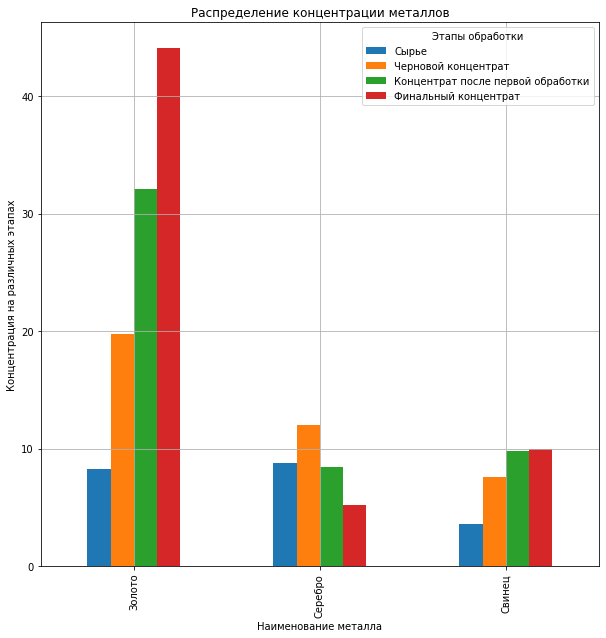

In [21]:
#посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: 
#в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате
(
    pd
    .DataFrame({'Металл': ['Золото', 'Серебро', 'Свинец'],
              'Сырье': 
              list(data_full[['rougher.input.feed_au', 'rougher.input.feed_ag', 
                              'rougher.input.feed_pb']].mean().round(2)),
              'Черновой концентрат':
              list(data_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 
                               'rougher.output.concentrate_pb']].mean().round(2)),
              'Концентрат после первой обработки':
              list(data_full[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 
                               'primary_cleaner.output.concentrate_pb']].mean().round(2)),
              'Финальный концентрат':
              list(data_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 
                               'final.output.concentrate_pb']].mean().round(2))})
    .plot(x='Металл', y = ['Сырье', 'Черновой концентрат', 'Концентрат после первой обработки', 
                           'Финальный концентрат'], 
          kind='bar', title='Распределение концентрации металлов', grid=True, figsize=(10, 10))
)

plt.ylabel("Концентрация на различных этапах")
plt.xlabel("Наименование металла")

plt.legend(title='Этапы обработки')

plt.show()

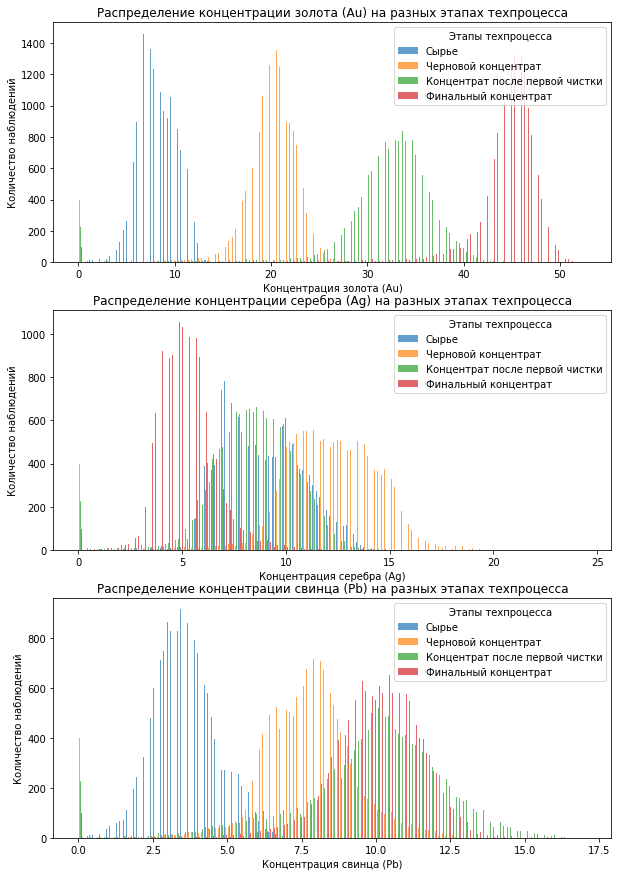

In [22]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)

plt.hist(data_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                    'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']],
         label = ('Сырье', 'Черновой концентрат', 'Концентрат после первой чистки', 'Финальный концентрат'),
         alpha=0.7, bins=150)

plt.xlabel('Концентрация золота (Au)')
plt.ylabel('Количество наблюдений')

plt.title('Распределение концентрации золота (Au) на разных этапах техпроцесса')

plt.legend(title = 'Этапы техпроцесса')

plt.subplot(3, 1, 2)

plt.hist(data_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                    'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']],
         label = ('Сырье', 'Черновой концентрат', 'Концентрат после первой чистки', 'Финальный концентрат'),
         alpha=0.7, bins=150)

plt.xlabel('Концентрация серебра (Ag)')
plt.ylabel('Количество наблюдений')

plt.title('Распределение концентрации серебра (Ag) на разных этапах техпроцесса')

plt.legend(title = 'Этапы техпроцесса')

plt.subplot(3, 1, 3)

plt.hist(data_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                    'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']],
         label = ('Сырье', 'Черновой концентрат', 'Концентрат после первой чистки', 'Финальный концентрат'),
         alpha=0.7, bins=150)

plt.xlabel('Концентрация свинца (Pb)')
plt.ylabel('Количество наблюдений')

plt.title('Распределение концентрации свинца (Pb) на разных этапах техпроцесса')

plt.legend(title = 'Этапы техпроцесса')

plt.show()

В процессе обработки сырья концентрация золота увеличивается, что логично, так как техпроцессы осуществляются для обогащения исходного сырья. Концентрация свинца также увеличивается, а концентрация серебра снижается.
На графиках видно, что имеется достаточно большое количество наблюдений с нулевыми значениями после флотации. Исключим строки с нулевыми значениями как аномалии.

In [23]:
#количество аномальных значений

(data_full[data_full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
                      'final.output.concentrate_ag']] == 0]
 [['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag']].count())

rougher.output.concentrate_au            394
primary_cleaner.output.concentrate_au    108
final.output.concentrate_ag               98
dtype: int64

In [24]:
#создадим переменную с индексами аномальных значений

list_index = data_full[(data_full['rougher.output.concentrate_au'] == 0)|(data_full['primary_cleaner.output.concentrate_au'] == 0)|(data_full['final.output.concentrate_ag'] == 0)].index

In [25]:
#исключим строки с аномальными значениями

data_full = data_full.drop(list_index)

In [26]:
data_train = data_train.drop(list_index)
data_train.shape

(13988, 54)

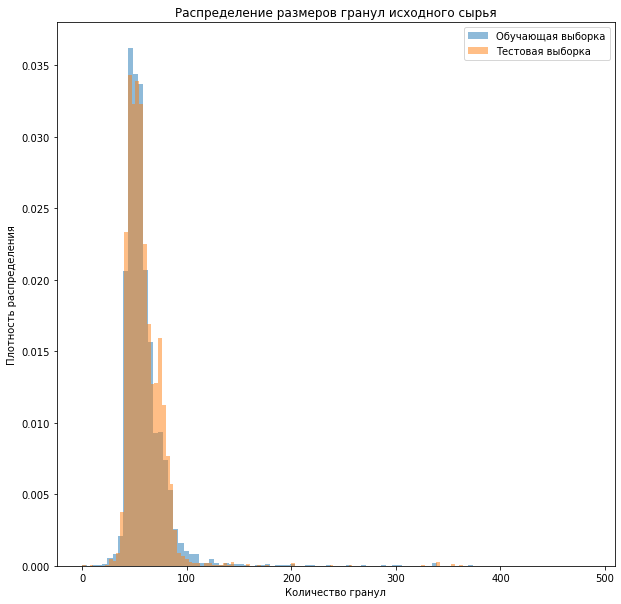

In [27]:
#сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках

plt.figure(figsize=(10,10))

plt.hist(data_train['rougher.input.feed_size'], density=True, alpha=0.5, bins=100)
plt.hist(data_test['rougher.input.feed_size'], density=True, alpha=0.5, bins=100)

plt.xlabel('Количество гранул')
plt.ylabel('Плотность распределения')

plt.title('Распределение размеров гранул исходного сырья')

plt.legend(['Обучающая выборка','Тестовая выборка'])

plt.show()

Распределения размеров гранул исходного сырья на обучающей и тестовой выборках нормальные и идентичные.

Сравним распределение в выборках с использованием статистического теста

Нулевая гипотеза: Средние значения размеров гранул в выборках равны\
Альтернативная гипотеза: Средние значения размеров гранул в выборках не равны

In [28]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9227216631030302
Не получилось отвергнуть нулевую гипотезу


Средние значения размеров гранул в выборках равны.

In [29]:
#рассмотрим суммарную концентрацию металлов на разных стадиях: 
#в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате

feed_total = (data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + 
              data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol'])

rougher_total = (data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag'] + 
                 data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol'])
                 
cleaner_total = (data_full['primary_cleaner.output.concentrate_au'] + 
                 data_full['primary_cleaner.output.concentrate_ag'] +
                 data_full['primary_cleaner.output.concentrate_pb'] + 
                 data_full['primary_cleaner.output.concentrate_sol'])

final_total = (data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] +
               data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol'])        

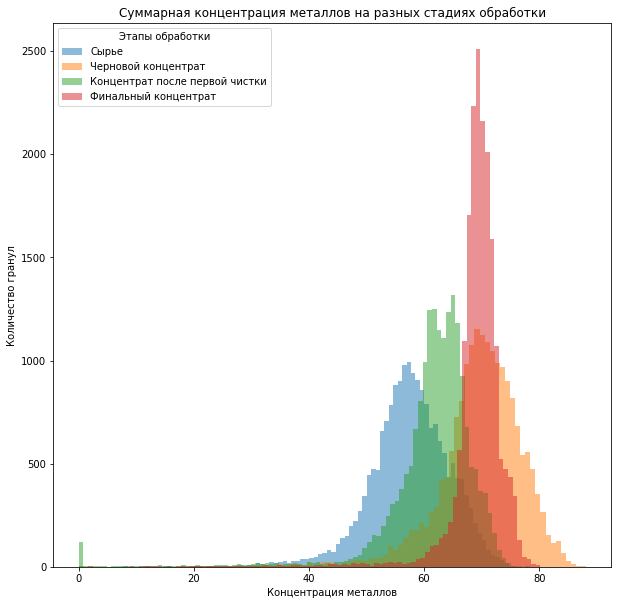

In [30]:
plt.figure(figsize=(10,10))

plt.hist(feed_total, label = 'Сырье', alpha=0.5, bins=100)
plt.hist(rougher_total, label = 'Черновой концентрат', alpha=0.5, bins=100)
plt.hist(cleaner_total, label = 'Концентрат после первой чистки', alpha=0.5, bins=100)
plt.hist(final_total, label = 'Финальный концентрат', alpha=0.5, bins=100)

plt.xlabel('Концентрация металлов')
plt.ylabel('Количество гранул')

plt.title('Cуммарная концентрация металлов на разных стадиях обработки')

plt.legend(title = 'Этапы обработки')

plt.show()

Суммарная концентрация металлов в продукте увеличивается после прохождения всех этапов обработки.

__Вывод__

По итогам анализа исходных данных сформулированы следующие выводы:
* в процессе обработки сырья концентрация золота увеличивается, что логично, так как техпроцессы осуществляются для обогащения исходного сырья. Концентрация свинца также увеличивается, а концентрация серебра снижается.
* наблюдения с нулевой концентрацией золота после этапов обработки исключены как аномальные.
* распределения размеров гранул исходного сырья на обучающей и тестовой выборках нормальные и идентичные.
* суммарная концентрация металлов в продукте увеличивается после прохождения всех этапов обработки.

## Модель

In [31]:
#напишем функцию для вычисления итогового sMAPE

def smape(y_true, y_pred):
    error = (100 * ((abs(y_true - y_pred)) / ((abs(y_true) + abs(y_pred)) / 2)).mean())
    return error

In [32]:
def final_smape(smape_rougher, smape_final):
    return (0.25 * smape_rougher) + (0.75 * smape_final)

In [33]:
score = make_scorer(smape, greater_is_better=False)

In [34]:
#разделим выборки на признаки (X) и целевую переменную (y)

X_train = data_train.drop((['rougher.output.recovery', 'final.output.recovery']), axis=1)
y_train_rougher = data_train['rougher.output.recovery']
y_train_final = data_train['final.output.recovery']

X_test = data_test.drop((['rougher.output.recovery', 'final.output.recovery']), axis=1)
y_test_rougher = data_test['rougher.output.recovery']
y_test_final = data_test['final.output.recovery']

In [35]:
#создадим пайплайн для обучения модели

model1 = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model2 = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=12345))
model3 = make_pipeline(StandardScaler(), LinearRegression())

In [73]:
#определим параметры для GridSearchCV

parameters_DTR = {'decisiontreeregressor__max_depth':[None] + [i for i in range(2, 7)],
                  'decisiontreeregressor__min_samples_split':[2,3], 
                  'decisiontreeregressor__min_samples_leaf':[1,2,3]}

parameters_RFR = {'randomforestregressor__n_estimators':[i for i in range(1, 22, 10)], 
                  'randomforestregressor__max_depth':[None] + [i for i in range(2, 5)],
                  'randomforestregressor__min_samples_split':[1,2,3], 
                  'randomforestregressor__min_samples_leaf':[1,2,3]}

In [74]:
#найдем лучшие комбинации гиперпараметров для моделей

grid_DTR_rougher = GridSearchCV(model1,param_grid = parameters_DTR,cv=3,scoring=score)
grid_DTR_final = GridSearchCV(model1,param_grid = parameters_DTR,cv=3,scoring=score)
grid_RFR_rougher = GridSearchCV(model2,param_grid = parameters_RFR,cv=3,scoring=score)
grid_RFR_final = GridSearchCV(model2,param_grid = parameters_RFR,cv=3,scoring=score)

In [75]:
#обучим модель решающего дерева

grid_DTR_rougher.fit(X_train, y_train_rougher)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': [None, 2, 3, 4, 5,
                                                              6],
                         'decisiontreeregressor__min_samples_leaf': [1, 2, 3],
                         'decisiontreeregressor__min_samples_split': [2, 3]},
             scoring=make_scorer(smape, greater_is_better=False))

In [76]:
grid_DTR_final.fit(X_train, y_train_final)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': [None, 2, 3, 4, 5,
                                                              6],
                         'decisiontreeregressor__min_samples_leaf': [1, 2, 3],
                         'decisiontreeregressor__min_samples_split': [2, 3]},
             scoring=make_scorer(smape, greater_is_better=False))

In [77]:
#обучим модель случайного леса

grid_RFR_rougher.fit(X_train, y_train_rougher)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=12345))]),
             param_grid={'randomforestregressor__max_depth': [None, 2, 3, 4],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [1, 2, 3],
                         'randomforestregressor__n_estimators': [1, 11, 21]},
             scoring=make_scorer(smape, greater_is_better=False))

In [78]:
grid_RFR_final.fit(X_train, y_train_final)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=12345))]),
             param_grid={'randomforestregressor__max_depth': [None, 2, 3, 4],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [1, 2, 3],
                         'randomforestregressor__n_estimators': [1, 11, 21]},
             scoring=make_scorer(smape, greater_is_better=False))

In [79]:
print('Качество модели случайного леса для определения эффективноcти обогащения после флотации:', 
      grid_RFR_rougher.best_params_)
print('Качество модели случайного леса для определения эффективноcти обогащения финального концентрата:', 
      grid_RFR_final.best_params_)

Качество модели случайного леса для определения эффективноcти обогащения после флотации: {'randomforestregressor__max_depth': 4, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 21}
Качество модели случайного леса для определения эффективноcти обогащения финального концентрата: {'randomforestregressor__max_depth': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 21}


In [80]:
print('Качество модели решающего дерева для определения эффективноcти обогащения после флотации:', 
      abs(grid_DTR_rougher.best_score_))

Качество модели решающего дерева для определения эффективноcти обогащения после флотации: 6.86991771590755


In [81]:
print('Качество модели решающего дерева для определения эффективноcти обогащения финального концентрата:',
      abs(grid_DTR_final.best_score_))

Качество модели решающего дерева для определения эффективноcти обогащения финального концентрата: 9.66584647532297


In [82]:
print('Качество модели случайного леса для определения эффективноcти обогащения после флотации:', 
      abs(grid_RFR_rougher.best_score_))

Качество модели случайного леса для определения эффективноcти обогащения после флотации: 6.564525215099375


In [83]:
print('Качество модели случайного леса для определения эффективноcти обогащения финального концентрата:', 
      abs(grid_RFR_final.best_score_))

Качество модели случайного леса для определения эффективноcти обогащения финального концентрата: 9.486585652689094


In [84]:
#обучим модель линейной регрессии

LR_smape_rougher = pd.Series(cross_val_score(model3, X_train, y_train_rougher, cv=3, scoring=score)).mean()
print('Качество модели линейной регрессии для определения эффективноcти обогащения после флотации:', 
      abs(LR_smape_rougher))

Качество модели линейной регрессии для определения эффективноcти обогащения после флотации: 8.235503668932465


In [85]:
LR_smape_final = pd.Series(cross_val_score(model3, X_train, y_train_final, cv=3, scoring=score)).mean()
print('Качество модели линейной регрессии для определения эффективноcти обогащения финального концентрата:',
      abs(LR_smape_final))

Качество модели линейной регрессии для определения эффективноcти обогащения финального концентрата: 10.880798440721932


In [86]:
#найдем итоговый показатель smape для всех моделей на обучающей выборке

print('Итоговое sMAPE для модели решающего дерева:', abs(final_smape(grid_DTR_rougher.best_score_, 
                                                                 grid_DTR_final.best_score_)))
print('Итоговое sMAPE для модели случайного леса:', abs(final_smape(grid_RFR_rougher.best_score_, 
                                                                grid_RFR_final.best_score_)))
print('Итоговое sMAPE для модели линейной регрессии:', abs(final_smape(LR_smape_rougher, 
                                                                   LR_smape_final)))

Итоговое sMAPE для модели решающего дерева: 8.966864285469114
Итоговое sMAPE для модели случайного леса: 8.756070543291663
Итоговое sMAPE для модели линейной регрессии: 10.219474747774566


Лучший показатель smape у модели случайного леса, найдем итоговый smape для тестовой выборки

In [87]:
test_rougher_predict = grid_RFR_rougher.predict(X_test)
test_final_predict = grid_RFR_final.predict(X_test)

print('Итоговое sMAPE для тестовой выборки:', 
      final_smape(smape(y_test_rougher, test_rougher_predict), smape(y_test_final, test_final_predict)))

Итоговое sMAPE для тестовой выборки: 7.3381234681573915


In [88]:
#проверим модель на адекватность

model_rougher = DummyRegressor()
model_final = DummyRegressor()

model_rougher.fit(X_train, y_train_rougher)
model_final.fit(X_train, y_train_final)

rougher_predict = model_rougher.predict(X_test)
final_predict = model_final.predict(X_test)

print('Итоговое sMAPE для базисной модели:', 
      abs(final_smape(smape(y_test_rougher, rougher_predict), smape(y_test_final, final_predict))))

Итоговое sMAPE для базисной модели: 8.472648251321258


__Вывод__

Данные из обучающей выборки были обучены с помощью трех моделей - DecisionTreeRegressor, RandomForestRegressor и LinearRegression, качество оценено кросс-валидацией. Лучший показатель качества определен у модели случайного леса. 
При проверке лучшей модели на тестовой выборке получено итоговое sMAPE: 7.3381234681573915.

## Общий вывод

В рамках проекта построена модель, способная предсказать коэффициент восстановления золота из золотосодержащей руды на основании данных с параметрами добычи и очистки. 

При подготовке данных к обучению проведена проверка расчета одного из целевых признаков - эффективность обогащения после флотации. Значение среднего абсолютного отклонения между проведеными расчетами и значением признака в обучающей выборке стремится к 0 - значит, что данные эффективности обогащения корректны.\
По причине более позднего замерения и/или расчета в тестовой выборке отсутствуют некоторые признаки - итоговые данные о концентрации металлов в продукте и отвальных хвостах после каждой стадии обработки, расчетные характеристики этапа флотации, а также целевые признаки - эффективности обогащения чернового и финального концентрата.\
При предобработке данных в тестовую выборку добавлены столбцы с целевыми признаками - `rougher.output.recovery` и `final.output.recovery`. Cтолбец `date` задан как индекс-столбец, тем самым исключен из признаков для обучения модели как избыточный. Также из обучающей выборки удалены признаки, отсутствующие в тестовой выборке. Данные индексируются датой и временем получения информации, соседние по времени параметры часто похожи, поэтому пропуски в данных обучающей и тестовой выборок заполнены методом _ffill_.\
Целевые признаки представлены числовыми значениями, решается задача регрессии обучением с учителем.

По итогам анализа исходных данных сформулированы следующие выводы:
* в процессе обработки сырья концентрация золота увеличивается, что логично, так как техпроцессы осуществляются для обогащения исходного сырья. Концентрация свинца также увеличивается, а концентрация серебра снижается.
* наблюдения с нулевой концентрацией золота после этапов обработки исключены как аномальные.
* распределения размеров гранул исходного сырья на обучающей и тестовой выборках нормальные и идентичные.
* суммарная концентрация металлов в продукте увеличивается после прохождения всех этапов обработки.

Данные из обучающей выборки были обучены с помощью трех моделей - DecisionTreeRegressor, RandomForestRegressor и LinearRegression, качество оценено кросс-валидацией. Лучший показатель качества определен у модели случайного леса. \
При проверке лучшей модели на тестовой выборке получено итоговое sMAPE: 7.3381234681573915.\
Проверку на адекватность модель прошла.